In [1]:
using Pkg;Pkg.status()

    Status `~/.julia/environments/v1.3/Project.toml`
  [1537fe66] CALCEPH v1.1.0
  [2e2c70e5] DataFitting v0.1.0
  [a93c6f00] DataFrames v0.21.8
  [31c24e10] Distributions v0.23.12
  [c91e804a] Gadfly v1.3.1
  [7073ff75] IJulia v1.23.2
  [42fd0dbc] IterativeSolvers v0.8.4
  [033835bb] JLD2 v0.2.4
  [2fda8390] LsqFit v0.11.0
  [6e857e4b] MCMCDiagnostics v0.3.0
  [429524aa] Optim v1.2.0
  [c3e4b0f8] Pluto v0.14.9
  [438e738f] PyCall v1.92.1
  [d330b81b] PyPlot v2.9.0
  [2913bbd2] StatsBase v0.33.2
  [f3b207a7] StatsPlots v0.14.14
  [1986cc42] Unitful v1.4.1
  [6112ee07] UnitfulAstro v1.0.1
  [8bb1440f] DelimitedFiles 
  [37e2e46d] LinearAlgebra 
  [9a3f8284] Random 
  [10745b16] Statistics 


### Testing longitude calculation

Using $\sqrt{e} \cos{\omega}$ and $\sqrt{e} \sin{\omega}$ as priors, doesnt work properly. don't know why. Reverted to previous prior $e \cos{\omega}$ and $e \sin{\omega}$

Using original prior on eccentricity.

In [124]:
calc_rad(value) = value * pi/180
calc_deg(value) = value * 180/pi
calc_omega(pomega,Omega) = pomega - Omega

calc_omega (generic function with 1 method)

In [122]:
g=jldopen("FITS/fromEMB/p3_fit30.0s30.0yrs.jld2","r")
tt,tt0,sigtt,ttmodel = g["tt"],g["tt0"],g["sigtt"],g["ttmodel"]
pbest_global = g["best_p3"]
nplanet,ntrans = g["nplanet"],g["ntrans"]
pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
n1,n2,n3 = ntrans
mu1,P1,t01,ecosw1,esinw1 = pbest_global[1:5]
mu2,P2,t02,ecosw2,esinw2 = pbest_global[6:10]
mu3,P3,t03,ecosw3,esinw3 = pbest_global[11:15]
time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
tt1 = tt[1:n1]
tt2 = tt[n1+1:n1+n2];

Calculate mean longitudes using Equation 5 from Agol & Deck 2015

In [123]:
function calc_L(t,t0,P,esinw)
    lambda = (360/P .* (t.-t0)) .+ 2*esinw
    return lambda
end

calc_L (generic function with 1 method)

$L \equiv \lambda$. Check to see if $\lambda_{E} \sim \lambda_{V}$ at their respective transit times. $\lambda mod 2 \pi = \lambda_{obs}$[what?] where $\lambda_{obs}$ is longitude that both Earth and Venus have.
true $\lambda$ from planet body data sheet: 181.9, 100, 34 degrees ##181.97973, 100.46435, 34.40438

In [125]:
J2000 = 2451545.0

w1 = calc_deg(atan(esinw1,ecosw1))
w2 = calc_deg(atan(esinw2,ecosw2))
w3 = calc_deg(atan(esinw3,ecosw3))
w1,w2,w3

(110.24093749596905, 34.5333600284138, -69.08910379986942)

Calculate angular diffence between J2000 and time of periastron passage

In [206]:
M1,M2,M3=(J2000-t01)/P1 , (J2000-t02)/P2 , (J2000-t03)/P3

(80.29004012099195, 49.063055930544984, 2.973418764877712)

In [167]:
L_1 = calc_L(tt1,t01,P1,esinw1)
L_2 = calc_L(tt2,t02,P2,esinw2)
L_3 = calc_L(tt1,t03,P3,esinw3)
L_1,L_2,L_3

([0.012371787476397042, 360.0133343565473, 720.0169824870229, 1080.0135526690897, 1440.0122255198048, 1800.0170057665478, 2160.0177544631683, 2520.01589496752, 2880.0098961630033, 3240.010708947574  …  14040.012713830656, 14400.014083406671, 14760.016677415953, 15120.013983489262, 15480.011012335533, 15840.016055447844, 16200.017730867143, 16560.01607892639, 16920.011100616346, 17280.00925384235], [0.0193074189826956, 360.01755401405876, 720.0184902573101, 1080.015305463873, 1440.017709387891, 1800.0183440440064, 2160.0145286887832, 2520.0146528520695, 2880.014883589056, 3240.0152534528497  …  7560.018441732332, 7920.0166871745005, 8280.01969911849, 8640.01972129125, 9000.016764160737, 9360.017518242807, 9720.014787497934, 10080.016042194638, 10440.018009102552, 10800.01309921289], [-472.01679167601947, -452.80685458852207, -433.5967741973367, -414.387071491096, -395.1772565847874, -375.9671157829794, -356.7571901078858, -337.5474036080016, -318.337837984924, -299.12790889004646  …  27

I can't recall where the following numbers come from or how to find the reference angle that ends up being 77 degs

In [152]:
28904.409642330258-28722.430890811236

181.9787515190219

In [153]:
17662.6994287092-17562.229939921457

100.46948878774128

In [154]:
679.195296805864-644.8690628197218

34.326233986142256

Venus transit occurs 0.277 radians after it goes through periastron. Earth transit occurs -0.552 radians after it goes through periastron

In [135]:
L_1[end].+w1

17390.250191338317

In [115]:
L_1+w1,L_2+w2,L_3+w3

(-2.9193164641747487, 9.181361870724214, -728.3880501771732)

In [197]:
Dw1 = (((360/P1) .* (t01.- J2000)) .+ 181.97909950) + 360*80

77.56465594290057

In [192]:
Dw2 = ((360/P2) .* (t02 .- J2000) .+ 100.46457166) + 360*49.06304030994849

100.46457165999891

In [191]:
Dw3 = [(360/P3) .* (t03 .- J2000) .+ 34.39644051,(360/P3) .* (t03 .- J2000) .+ 34.39644051 + 360*1,(360/P3) .* (t03 .- J2000) .+ 34.39644051 + 360*2]

3-element Array{Float64,1}:
 -644.8690628197218 
 -284.86906281972176
   75.13093718027824

In [199]:
calc_evec1(e,omega) = e* cos(omega-77)
calc_evec2(e,omega) = e* sin(omega-77)
    trueec4=calc_evec1(0.04839266,14.75385)
    truees4=calc_evec2(0.04839266,14.75385)
println(trueec4," ",truees4)

0.040326747776546754 0.026750756169543723


Calculate lunar phase offset, $\Delta\phi= (P_p/P_s - round(P_p/P_s))*2\pi$ 

In [213]:
calc_dphi(P_p,P_s) = (P_p/P_s - round(P_p/P_s))*2pi

calc_dphi (generic function with 1 method)

In [217]:
dphi=calc_dphi(365.256355,27.322)
println(dphi," rad or ",calc_deg(dphi)," degrees")

2.315859255328402 rad or 132.68896127662714 degrees


In [214]:
err_dphi=calc_dphi()

365.25635535

$\delta t_{sar99}$ quoted in Kipping 2009

In [119]:
deltat_sar99(a_p,a_s,m_p,m_s,P_p) = (2*a_s*m_s*P_p) / (2*pi*a_p*m_p)
deltat_sar99(1.49e8,3.84e5,5.97e24,734.8e20,365.256355)

0.003687972556145138

This differs from Kipping 2009 by a factor of $2\sqrt{2}$

In [177]:
deltat_kip09=0.003687972556145138/(2*sqrt(2))

0.0013038952016400562

To calculate moon amplitude, use $t_{max} = \frac{M_s a_s P_p}{(M_s + M_p) 2\pi a_p}$ based on velocity of EMB about Sun

In [227]:
include("CGS.jl")
tmax(a_p,a_s,m_p,m_s,P_p) = (a_s*m_s*P_p) / (2*pi*a_p*(m_s+m_p))
tmax(CGS.AU,CGS.AMOON*CGS.AU,CGS.MEARTH,CGS.MMOON,365.256355)

0.0018137646001546222

propagate errors to find error on tmax

In [236]:
tmax_err(a_p,a_s,m_p,m_s,P_p,da_p,da_s,dm_p,dm_s,dP_p) = sqrt( (dm_s/m_s)^2 + (da_s/a_s)^2 + (dP_p/P_p)^2 + (da_p/a_p)^2 + (sqrt(dm_p^2 + dm_s^2)/(m_p+m_s))^2 )
tmax_err(CGS.AU,CGS.AMOON*CGS.AU,CGS.MEARTH,CGS.MMOON,365.256355,0.01,0.01,0.00005*CGS.MEARTH,0.00005*CGS.MEARTH,0.006355)

0.004069146741584305

In [189]:
1.5661176023428496 * 180/pi

89.73192883539303

In [208]:
0.000030e27/CGS.MEARTH

5.021592849251782e-6

In [203]:
    trueec3=calc_evec1(0.09341233,336.04084)
    truees3=calc_evec2(0.09341233,336.04084)
println(trueec3," ",truees3)

0.013086282283637845 0.0924911488306954


## Transit Timing plots

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


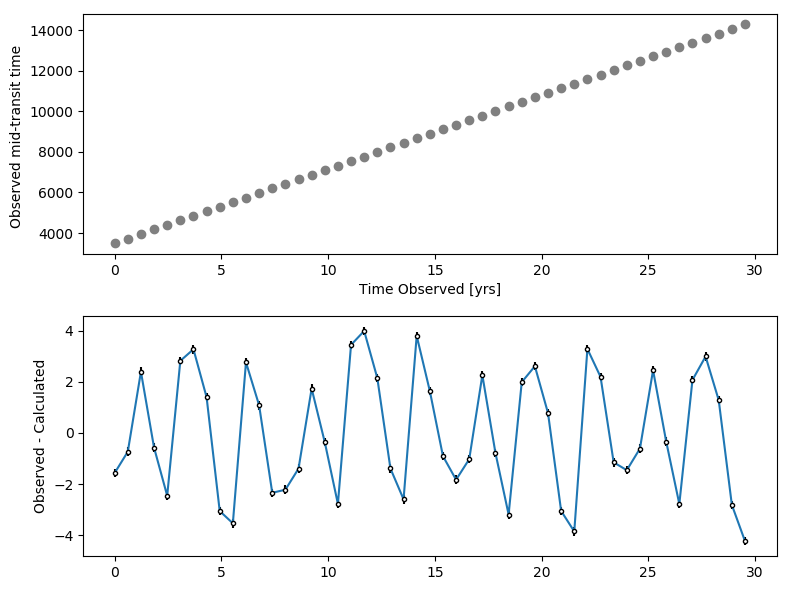

In [4]:
include("plot_ttvs.jl")
plot_ex(10.0,30.0,"EMB","p3",false) 

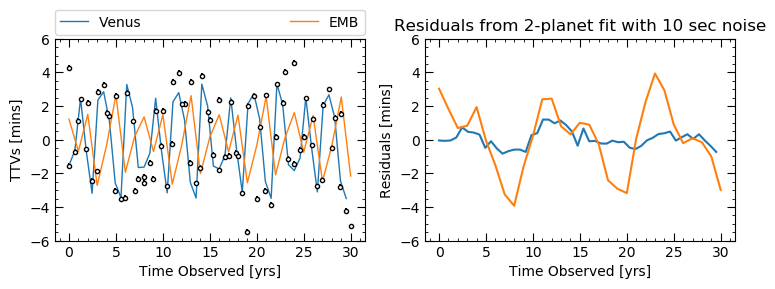

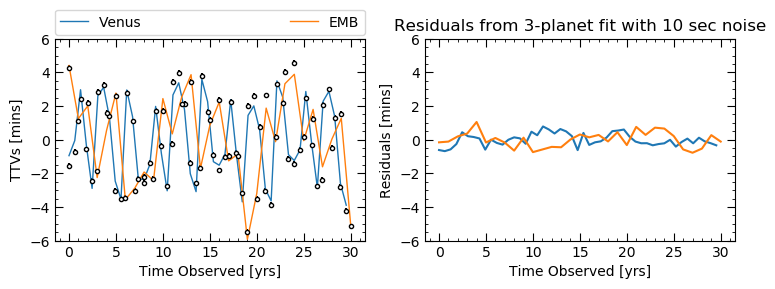

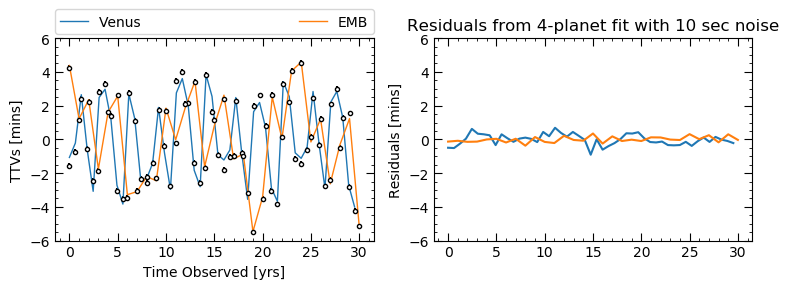

In [13]:
include("plot_ttvs.jl")
plot_res(10.0,30.0,"EMB","p4",false) 

plot_res(10.0,30.0,"noEMB","moon",true)  

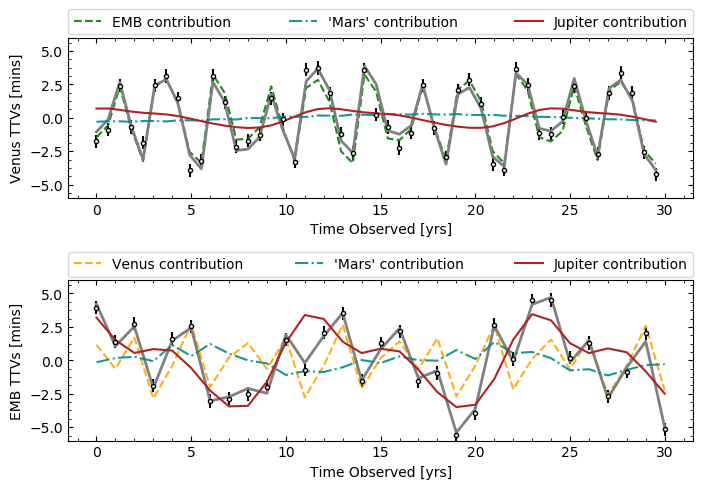

best_p4


In [30]:
include("plot_ttvs.jl")
plot_ttvs(30.0,30.0,"EMB","p4",false)

plot_ttvs(30.0,30.0,"noEMB","moon",true)

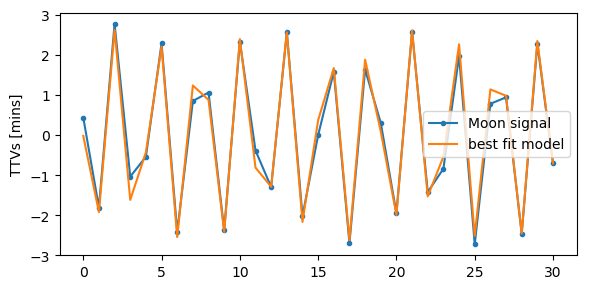

In [258]:
include("plot_ttvs.jl")
plot_moon(30.0,30.0,"p3")

## Likelihoods/Probabilities

In [5]:
using JLD2
test4=jldopen("FITS/fromEMB/p4_fit30.0s30.0yrs.jld2","r");test5=jldopen("FITS/fromEMB/p5_fit30.0s30.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/fromEMB/p5_fit30.0s30.0yrs.jld2 (read-only)
 ├─🔢 p4
 ├─🔢 lprob_p4
 ├─🔢 best_p4
 ├─🔢 lprob_best_p4
 ├─🔢 p5
 ├─🔢 lprob_p5
 ├─🔢 best_p5
 ├─🔢 lprob_best_p5
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 └─🔢 sigtt

### 30 second added Gaussian noise with 30 years of observations

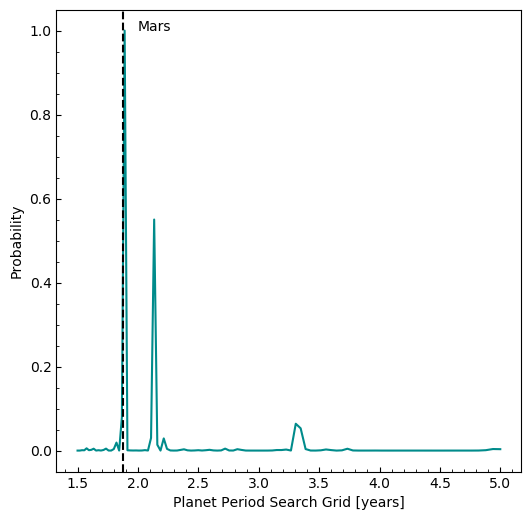

In [11]:
include("plot_likelihood.jl")
#plot_prob(xgrid::Vector,lprob::Vector,truex::Float64,nbins::Int,param::Vector,color::String,text::String)
prob(test4["p4"],test4["lprob_p4"],1.88, 50, test4["best_p4"],"darkcyan","Mars")

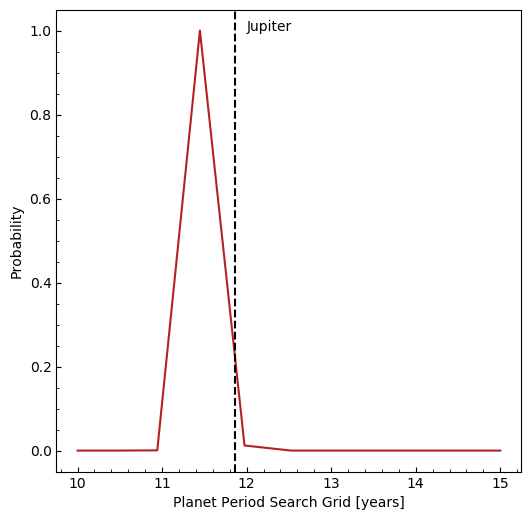

In [13]:
prob(test4["p3"],test4["lprob_p3"],11.86, 50, test4["best_p3"],"firebrick","Jupiter")

In [15]:
test4["best_p4"]

20-element Array{Float64,1}:
    2.480121883126103e-6 
  224.70077540515388     
    2.433503765444703e6  
   -0.005939055657794609 
    0.005909743098529525 
    2.978028749003477e-6 
  365.2564548698862      
    2.433624402152881e6  
    0.008832863560751842 
    0.008142963125268353 
    3.9749570978363227e-7
  687.1785755198679      
    2.439352062754473e6  
   -0.10232003112795145  
   -0.07961133624641668  
    0.001001545153863733 
 4355.752877184778       
    2.4389782604761613e6 
    0.026232037694501966 
   -0.04558741075290343  

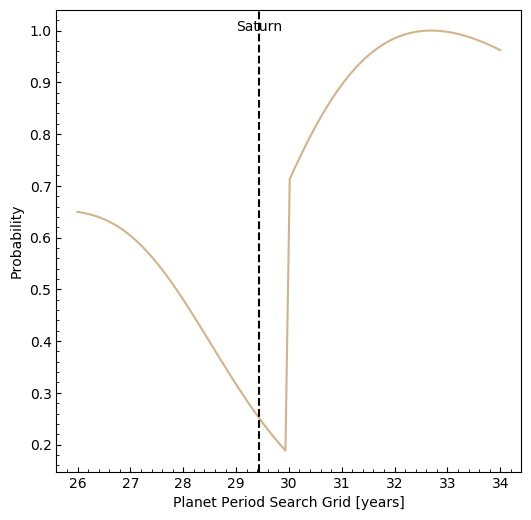

In [12]:
prob(test5["p5"],test5["lprob_p5"],29.44, 50, test5["best_p5"],"tan","Saturn")

In [14]:
test5["best_p5"]

25-element Array{Float64,1}:
     2.5780650301911736e-6
   224.70078633035413     
     2.4335037651523524e6 
     0.0009419816526868568
     0.00830037608357883  
     3.0227094416397e-6   
   365.2564730735009      
     2.433624401845437e6  
     0.014485918268009578 
     0.00976819700928585  
     5.375591170452615e-7 
   686.0660810155342      
     2.439444760476603e6  
    -0.03403462657735575  
     0.12884432652463723  
     0.0008554379571638908
  4395.18405269475        
     2.4389576904200655e6 
     0.022210715753002593 
    -0.055797898450499706 
     0.008033401903875904 
 11956.211987815295       
     2.4450392179923193e6 
     0.07174471513224069  
     0.002867299825955935 

In [27]:
test4=jldopen("FITS/fromEMB/p4_fit30.0s40.0yrs.jld2","r");test5=jldopen("FITS/fromEMB/p5_fit30.0s40.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/fromEMB/p5_fit30.0s40.0yrs.jld2 (read-only)
 ├─🔢 p4
 ├─🔢 lprob_p4
 ├─🔢 best_p4
 ├─🔢 lprob_best_p4
 ├─🔢 p5
 ├─🔢 lprob_p5
 ├─🔢 best_p5
 ├─🔢 lprob_best_p5
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 └─🔢 sigtt

### 30 second added Gaussian noise with 40 years of observations

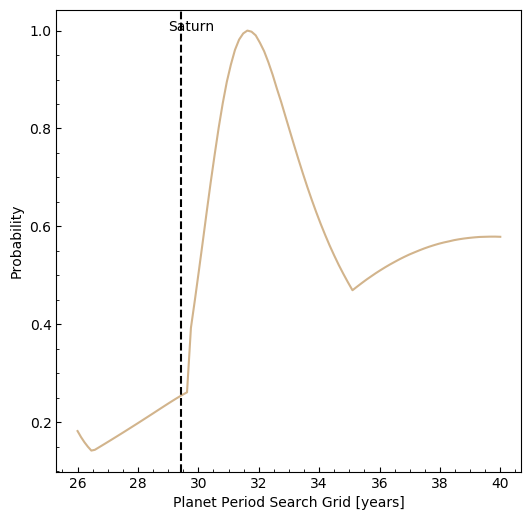

In [28]:
prob(test5["p5"],test5["lprob_p5"],29.44, 50, test5["best_p5"],"tan","Saturn")

In [19]:
test5["best_p5"]

25-element Array{Float64,1}:
     2.4004860885755717e-6
   224.70077199220466     
     2.433503765441179e6  
     0.004439176780367959 
     0.007699005722657725 
     3.0277165072616155e-6
   365.256471065888       
     2.4336244018786047e6 
     0.015739960402623633 
     0.00925615468471263  
     1.2386118627667822e-7
   683.2080679672084      
     2.440789540158629e6  
    -0.29239639837528586  
     0.138233290323028    
     0.0009626761839773262
  4306.898437740715       
     2.443370365812942e6  
     0.03293695415691274  
    -0.03757123814326818  
     0.0029459078827641376
 11551.784131496777       
     2.445382632790373e6  
     0.07395421708116241  
     0.011463016234465325 

In [2]:
include("plot_likelihood.jl")
# p3in,p3out=10.8*365.25,12.3*365.25
# dpin,dpout=2.2,2.38
# jd1=2.4332825e6
# np3,nphase,ndp=200,36,180 #wide: 100,36,180 
# p3in,p3out,dpin,dpout=zeros(4)
# p4in,p4out,np4= 1.5*365.25,5*365.25,100
sigma=10.0
nyear=15.0
datafile=string("INPUTS/tt_",sigma,"snoEMB",nyear,"yrs.txt")
lprob_best_p3,best_p3,lprob_p3,p3=fit_planet3(datafile,2.4332825e6,sigma,nyear,8*365.25,15*365.25,100,36,true,false)

Initial parameters: [3.0e-6, 224.70081459062885, 2.433503768458583e6, 0.01, 0.01, 3.0e-6, 365.256407448393, 2.433624408091723e6, 0.01, 0.01]
Initial chi-square: 7.019269262347504e21


InterruptException: [91mInterruptException:[39m

In [ ]:
plot(p3,exp.(lprob_p3 .- maximum(lprob_p3)),".")

jupiter period agreement --> unique solution & not degenerate

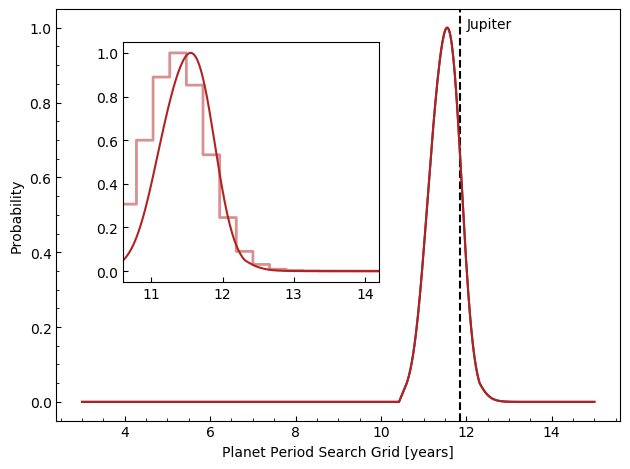

Loading...MCMC/p3_mcmc90.0s25.0yrs.jld2 and FITS/moon_fit90.0s25.0yrs.jld2


In [52]:
include("plot_likelihood.jl")
plot_likelihood(90.0,25.0,"noEMB","moon","p3",50)

In [ ]:
include("plot_likelihood.jl")
plot_likelihood(30.0,40.0,"EMB","moon","p3",50)

### 2 Planet Fits with MCMC

In [ ]:
1-sum(m_33["ntrans"][1:2] )/2 * log(667.8479408806473)

In [ ]:
MCMC("MCMC/p2_mcmc30.0s30.0yrs.jld2",[4.513519229108455e-6, 224.70077801541302, 2.4335037687537777e6, -0.0175050266179791, -0.025801638584714393, 2.964754129377914e-6, 365.25643897142635, 2.4336244077652446e6, 0.003030566580559538, -0.01953468392084722],
    -259.1624205684809,10000,50,2,m_33["ntrans"][1:2],m_33["tt0"],m_33["tt"],m_33["sigtt"],true,true)

In [260]:
p2 = jldopen("p2mc.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/p2mc.jld2 (read-only)
 ├─🔢 par_mcmc
 ├─🔢 lprob_mcmc
 ├─🔢 param
 ├─🔢 nwalkers
 ├─🔢 nsteps
 ├─🔢 accept
 ├─🔢 iburn
 └─🔢 indepsamples

In [263]:
par_mcmc,lprob_mcmc = p2["par_mcmc"],p2["lprob_mcmc"]
iburn,samples = p2["iburn"], p2["indepsamples"]
nwalkers,nsteps = p2["nwalkers"],p2["nsteps"]
param = p2["param"]
pname = ["mu_1","P_1","t01","ecos1","esin1",
      "mu_2","P_2","t02","ecos2","esin2",
      "mu_3","P_3","t03","ecos3","esin3", 
        "tcosϕ","tsinϕ","Δϕ","σ_sys"]
# open(output,"w") do io
for i=1:length(param)
println(pname[i]," : ",mean(vec(par_mcmc[:,iburn:nsteps,i]))," ± ",std(vec(par_mcmc[:,iburn:nsteps,i]))) # writedlm(results,pbest_global)
end
println(pname[end]," : ",mean(vec(par_mcmc[:,iburn:nsteps,end]))," ± ",std(vec(par_mcmc[:,iburn:nsteps,end])))
println("Derived Parameters")
for i=1:length(param)
    if i%5 == 0
        println("M_p : ",mean(vec(par_mcmc[:,iburn:nsteps,i-4])).* CGS.MSUN/CGS.MEARTH," ± ",std(vec(par_mcmc[:,iburn:nsteps,i-4])).* CGS.MSUN/CGS.MEARTH)
    end     
end

mu_1 : 4.15928839022942e-6 ± 6.18624288956681e-7
P_1 : 224.7007782552164 ± 1.1011795602155861e-5
t01 : 2.433503768748378e6 ± 0.0003064855070134959
ecos1 : -0.04524200381676317 ± 0.04719561805271115
esin1 : -0.029054354682061186 ± 0.026065807661185738
mu_2 : 2.811078330926699e-6 ± 3.6966917569485863e-7
P_2 : 365.2564389550426 ± 2.2166325330020126e-5
t02 : 2.4336244077640874e6 ± 0.0003859248199815893
ecos2 : -0.018971095766740182 ± 0.037195887044490575
esin2 : -0.021941708357377968 ± 0.02050288413578409
σ_sys : 1.078103508760054e-6 ± 2.1171634747807726e-7
Derived Parameters
M_p : 1.3847028665085028 ± 0.20595129402961435
M_p : 0.9358591801323574 ± 0.1230696021095742


In [6]:
sig(systematic,noise) = sqrt((systematic*24*3600)^2 + noise^2)
#from EMBp3 chain, 10s20yrs
sig(8.898475627882412e-8,10)

10.000002955484293

In [7]:
#from noEMBp3 chain, 10s20yrs
sig(2.6823596703783866e-7,10)

10.00002685535686

In [8]:
#from EMBp3 30s30yrs
sig(9.364261795690401e-8,30)

30.000001090996406

In [9]:
#from noEMBp3 30s30yrs
sig(3.153758343629319e-7,30)

30.000012374651302

In [10]:
#from noEMBmoon 30s30yrs
sig(1.0142289737762594e-7,30)

30.00000127981811